# pytorch -> ONNX

In [1]:
import torch
from torch import nn
#import torch.onnx
import torchvision
import torch.nn.functional as F
print(torch.__version__)
from matplotlib import pyplot as plt

torch.manual_seed(1)

1.0.1


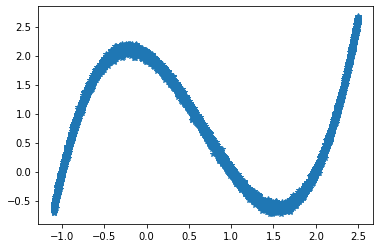

In [2]:
X = torch.linspace(-1.1, 2.5, 10000)
Y = (X - 1) * (X + 1) * (X - 2)
noise = torch.randn(X.size()) / 25
Y = Y + noise
# Reshape for training
X = torch.reshape(X, (-1,1))
Y = torch.reshape(Y, (-1,1))
# plot the function
plt.plot(X.cpu().numpy(),Y.cpu().numpy(), '*')

In [3]:
class LinearRegressionModel(nn.Module):

    def __init__(self, input_dim, output_dim):

        super(LinearRegressionModel, self).__init__() 
        self.linear0 = nn.Linear(input_dim, 16)
        self.linear1 = nn.Linear(16, 8)
        self.linear2 = nn.Linear(8, 4)        
        self.linear4 = nn.Linear(4, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        
        x = torch.relu(self.linear0(x))
        x = self.dropout(x)
        x = torch.relu(self.linear1(x))
        x = self.dropout(x)
        x = torch.relu(self.linear2(x))
        x = self.dropout(x)     
        x = self.linear4(x)
        return x

In [4]:
INPUT_DIM = 1
OUTPUT_DIM = 1
model = LinearRegressionModel(INPUT_DIM, OUTPUT_DIM)

criterion = nn.MSELoss()
l_rate = 0.01
optimiser = torch.optim.Adam(model.parameters(), lr = l_rate) #Stochastic Gradient Descent

epochs = 100

for epoch in range(epochs):
    # clear gradient
    optimiser.zero_grad()
    outputs = model.forward(X)
    loss = criterion(outputs, Y)
    loss.backward()
    optimiser.step()
    if epoch  == epochs - 1:
        # Print the finish result
        print('epoch {}, loss {}'.format(epoch,loss.data.item()))

epoch 99, loss 0.6955614686012268


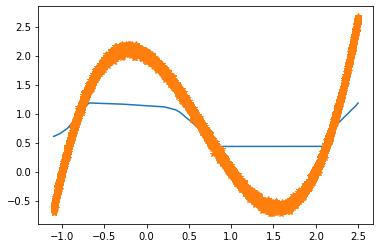

In [5]:
model.eval()
X_t = torch.linspace(-1.1, 2.5, 2000)
X_t = torch.reshape(X_t, (-1,1))
Y_t = model(X_t)
X_t = X_t.detach().cpu().numpy()
Y_t = Y_t.detach().cpu().numpy()
plt.plot(X_t,Y_t)
plt.plot(X.cpu().numpy(),Y.cpu().numpy(), '*')

In [6]:
sum([ p.numel() for p in model.parameters()])

209

In [7]:
dummy_input = torch.tensor([1], dtype=torch.float32)
torch.onnx.export(model, dummy_input, "model.onnx", verbose=True, input_names=['input_names'], output_names=['output_names'])

graph(%input_names : Float(1)
      %1 : Float(16, 1)
      %2 : Float(16)
      %3 : Float(8, 16)
      %4 : Float(8)
      %5 : Float(4, 8)
      %6 : Float(4)
      %7 : Float(1, 4)
      %8 : Float(1)) {
  %9 : Float(1!, 16) = onnx::Transpose[perm=[1, 0]](%1), scope: LinearRegressionModel/Linear[linear0]
  %10 : Float(16) = onnx::MatMul(%input_names, %9), scope: LinearRegressionModel/Linear[linear0]
  %11 : Float(16) = onnx::Add(%10, %2), scope: LinearRegressionModel/Linear[linear0]
  %12 : Float(16) = onnx::Relu(%11), scope: LinearRegressionModel
  %13 : Float(16), %14 : Tensor = onnx::Dropout[ratio=0.5](%12), scope: LinearRegressionModel/Dropout[dropout]
  %15 : Float(16!, 8!) = onnx::Transpose[perm=[1, 0]](%3), scope: LinearRegressionModel/Linear[linear1]
  %16 : Float(8) = onnx::MatMul(%13, %15), scope: LinearRegressionModel/Linear[linear1]
  %17 : Float(8) = onnx::Add(%16, %4), scope: LinearRegressionModel/Linear[linear1]
  %18 : Float(8) = onnx::Relu(%17), scope: LinearRegres